In [54]:
import numpy as np
import pandas as pd
import math
import sklearn
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [55]:
path = "C:/Users/prash/Downloads/STOCK MARKET/"

In [56]:
stock = 'RELIANCE'

In [57]:
df = pd.read_csv(path + "MONTHLY SHARE PRICES/" + stock + ".csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,16.009800,16.943001,11.874600,13.803500,2.072786,3553713872
1,1996-02-01,13.666900,19.129700,13.627800,16.544701,2.484416,6845404770
2,1996-03-01,16.673599,18.586901,15.033600,16.154200,2.425776,5383402631
3,1996-04-01,16.224501,20.500299,16.087900,19.106300,2.869075,4091974935
4,1996-05-01,20.851700,21.078199,17.614599,18.614300,2.795194,5445178207


In [58]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [59]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

    
new_data.head()

,Date,Close
0,1996-01-01,13.8035
1,1996-02-01,16.5447
2,1996-03-01,16.1542
3,1996-04-01,19.1063
4,1996-05-01,18.6143


In [60]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [61]:
#creating train and test sets
dataset = new_data.values

In [62]:
dataset[:train_set_size].size
dataset.size

288

In [63]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10

In [64]:
valid_set_size = int(np.round(valid_set_size_percentage/100*dataset.shape[0]));  
test_set_size = int(np.round(test_set_size_percentage/100*dataset.shape[0]))
train_set_size = dataset.shape[0] - (valid_set_size + test_set_size)

In [65]:
train = dataset[:train_set_size]
valid = dataset[train_set_size:train_set_size+valid_set_size]


In [66]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

C:\Users\prash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [67]:
pred_values = len(train)-2

In [68]:
x_train, y_train = [], []
for i in range(pred_values,len(train)):
    x_train.append(scaled_data[i-pred_values:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [69]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [70]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [71]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 4s - loss: 0.0634


In [72]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - pred_values:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [73]:
X_test = []
for i in range(pred_values,inputs.shape[0]):
    X_test.append(inputs[i-pred_values:i,0])
X_test = np.array(X_test)

In [74]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [75]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

342.1498517458221

C:\Users\prash\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


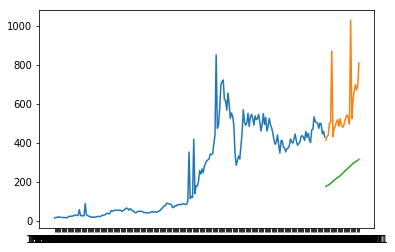

In [76]:
#for plotting
train = new_data[:train_set_size]
valid = new_data[train_set_size:train_set_size+valid_set_size]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])